## Model train from scratch on the Iris dataset

We will build, compile and fit a neural network model to the Iris dataset. We will also implement validation, regularisation and callbacks to improve our model.


In [1]:
# Run this cell first to import all required packages.
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection 
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split


#### The Iris dataset

We will use the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For a reference, see the following papers:

- R. A. Fisher. "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188, 1936.

Our goal is to construct a neural network that classifies each sample into the correct class, as well as applying validation and regularisation techniques.

#### Load and preprocess the data

First read in the Iris dataset using `datasets.load_iris()`, and split the dataset into training and test sets.

In [2]:
def read_in_and_split_data(iris_data):
    """
    This function takes the Iris dataset as loaded by sklearn.datasets.load_iris(), and then 
    splits so that the training set includes 90% of the full dataset, with the test set 
    making up the remaining 10%.
    Your function should return a tuple (train_data, test_data, train_targets, test_targets) 
    of appropriately split training and test data and targets.
    
    If you would like to import any further packages to aid you in this task, please do so in the 
    Package Imports cell above.
    """
    data = iris_data['data']
    targets = iris_data['target']
    
    train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
    
    return (train_data, test_data, train_targets, test_targets)    
    

In [3]:
# Run our function to generate the test and training data.
iris_data = datasets.load_iris()
train_data, test_data, train_targets, test_targets = read_in_and_split_data(iris_data)

We will now convert the training and test targets using a one hot encoder.

In [4]:
# Convert targets to a one-hot encoding

train_targets = tf.keras.utils.to_categorical(np.array(train_targets))
test_targets = tf.keras.utils.to_categorical(np.array(test_targets))

#### Building the neural network model


We can now construct a model to fit to the data. Using the Sequential API, build our model according to the following specifications:

* The model should use the `input_shape` in the function argument to set the input size in the first layer.
* The first layer should be a dense layer with 64 units.
* The weights of the first layer should be initialised with the He uniform initializer.
* The biases of the first layer should be all initially equal to one.
* There should then be a further four dense layers, each with 128 units.
* This should be followed with four dense layers, each with 64 units.
* All of these Dense layers should use the ReLU activation function.
* The output Dense layer should have 3 units and the softmax activation function.

In total, the network should have 10 layers.

In [5]:
def get_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the 
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should return the model.
    """
    model = Sequential([
                      Dense(64, activation='relu', kernel_initializer='he_uniform', bias_initializer='ones', input_shape=input_shape),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(3, activation='softmax')
    ])
    
    return model    
    

In [6]:
# Run our function to get the model

model = get_model(train_data[0].shape)

#### Compile the model

We should now compile the model using the `compile` method. 

In [7]:
def compile_model(model):
    """
    This function takes in the model returned from your get_model function, and compiles it with an optimiser,
    loss function and metric.
    Compile the model using the Adam optimiser (with learning rate set to 0.0001), 
    the categorical crossentropy loss function and accuracy as the only metric. 
    Your function doesn't need to return anything; the model will be compiled in-place.
    """
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])    
    

In [8]:
# Run our function to compile the model

compile_model(model)

#### Fit the model to the training data

Now we should train the model on the Iris dataset, using the model's `fit` method. 
* Runing the training for a fixed number of epochs, given by the function's `epochs` argument.
* Returnig the training history to be used for plotting the learning curves.
* Setting the batch size to 40.
* Setting the validation set to be 15% of the training set.

In [9]:
def train_model(model, train_data, train_targets, epochs):
    """
    This function should train the model for the given number of epochs on the 
    train_data and train_targets. 
    Your function should return the training history, as returned by model.fit.
    """
    history = model.fit(train_data, train_targets, epochs = epochs, validation_split=0.10, batch_size=64, verbose=False)
    
    return history    
    

In [10]:
# Run our function to train the model

history = train_model(model, train_data, train_targets, epochs=800)

#### Plot the learning curves

We will now plot two graphs:
* Epoch vs accuracy
* Epoch vs loss


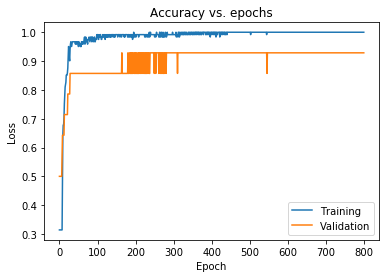

In [11]:
# Run this cell to plot the epoch vs accuracy graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

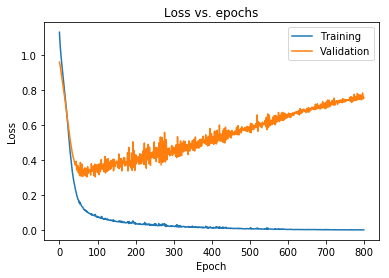

In [12]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

Oh no! We have overfit our dataset. You should now try to now try to mitigate this overfitting.

#### Reducing overfitting in the model

We should now define a new regularised model.
The specs for the regularised model are the same as our original model, with the addition of two dropout layers, weight decay, and a batch normalisation layer. 

In particular:

* Adding a dropout layer after the 3rd Dense layer
* Then there should be two more Dense layers with 128 units before a batch normalisation layer
* Following this, two more Dense layers with 64 units and then another Dropout layer
* Two more Dense layers with 64 units and then the final 3-way softmax layer
* Add weight decay (l2 kernel regularisation) in all Dense layers except the final softmax layer

In [13]:
def get_regularised_model(input_shape, dropout_rate, weight_decay):
    """
    This function should build a regularised Sequential model according to the above specification. 
    The dropout_rate argument in the function should be used to set the Dropout rate for all Dropout layers.
    L2 kernel regularisation (weight decay) should be added using the weight_decay argument to 
    set the weight decay coefficient in all Dense layers that use L2 regularisation.
    Ensure the weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument input_shape.
    Your function should return the model.
    """
    model = Sequential([
                      Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay), kernel_initializer='he_uniform', bias_initializer='ones', input_shape=input_shape),
                      Dense(128, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      Dense(128, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      Dropout(dropout_rate),
                      Dense(128, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      Dense(128, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      BatchNormalization(),
                      Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      Dropout(dropout_rate),
                      Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
                      Dense(3, activation='softmax')
    ])
    
    return model    
    

#### Instantiate, compile and train the model

In [14]:
# Instantiate the model, using a dropout rate of 0.3 and weight decay coefficient of 0.001

reg_model = get_regularised_model(train_data[0].shape, 0.3, 0.001)

In [15]:
# Compile the model

compile_model(reg_model)

In [16]:
# Train the model

reg_history = train_model(reg_model, train_data, train_targets, epochs=800)

#### Plot the learning curves

Let's now plot the loss and accuracy for the training and validation sets.

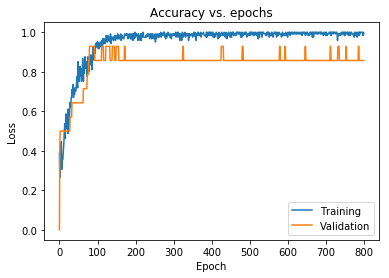

In [17]:
#Run this cell to plot the new accuracy vs epoch graph

try:
    plt.plot(reg_history.history['accuracy'])
    plt.plot(reg_history.history['val_accuracy'])
except KeyError:
    plt.plot(reg_history.history['acc'])
    plt.plot(reg_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

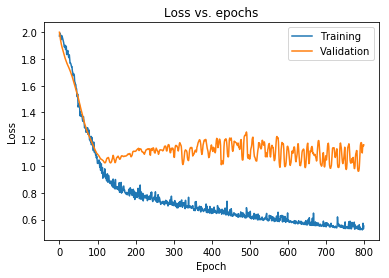

In [18]:
#Run this cell to plot the new loss vs epoch graph

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

We can see that the regularisation has helped to reduce the overfitting of the network.
We will now incorporate callbacks into a new training run that implements early stopping and learning rate reduction on plateaux.

Fill in the function below so that:

* It creates an `EarlyStopping` callback object and a `ReduceLROnPlateau` callback object
* The early stopping callback is used and monitors validation loss with the mode set to `"min"` and patience of 30.
* The learning rate reduction on plateaux is used with a learning rate factor of 0.2 and a patience of 20.

In [19]:
def get_callbacks():
    """
    This function should create and return a tuple (early_stopping, learning_rate_reduction) callbacks.
    The callbacks should be instantiated according to the above requirements.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min')
    lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.2)
    
    return early_stopping, lr_reduce    
    

In [20]:
call_model = get_regularised_model(train_data[0].shape, 0.3, 0.0001)
compile_model(call_model)
early_stopping, learning_rate_reduction = get_callbacks()
call_history = call_model.fit(train_data, train_targets, epochs=800, validation_split=0.15,
                         callbacks=[early_stopping, learning_rate_reduction], verbose=0)

In [21]:
learning_rate_reduction.patience

20

Finally, let's replot the accuracy and loss graphs for our new model.

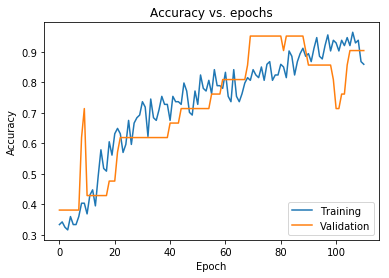

In [22]:
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

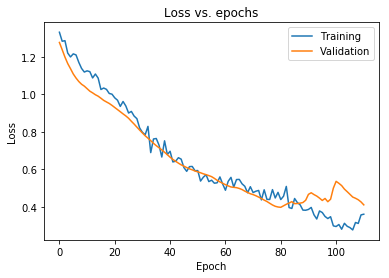

In [23]:
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [24]:
# Evaluate the model on the test set

test_loss, test_acc = call_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.548
Test accuracy: 73.33%
